In [1]:
import os
import ipywidgets as widgets
from ipywidgets import *
from bqplot import *
import numpy as np
import pandas as pd
import qgrid
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

# 1. Plots a bar graph representing the number of docstring errors.

To generate the file in `json` format, the following command needs to be executed in `master` branch clone of pandas,
after completing the development environment setup.

`./scripts/validate_docstrings.py --format=json > /path/to/json/pandas_docstring_errors.json`

This script currently supports pandas version >= 0.25.0

In [3]:
path = '../json/pandas_docstring_errors.json.zip'
df = (pd.read_json(path, compression='zip')
            .transpose()
            .filter(items=['errors'])
            .explode('errors')
            .dropna()
            .reset_index()
     )
df.head(2)

,index,errors
0,pandas.Categorical,"[PR01, Parameters {fastpath} not documented]"
1,pandas.Categorical,"[PR09, Parameter ""dtype"" description should fi..."


## 1) Split a list 'error' into separate data columns 'error_code' and 'error_name'

In [4]:
df[['error_code','error_name']] = pd.DataFrame(df.errors.tolist(), index=df.index)
df = df.drop(["errors","index"], axis=1)
df.head(2)

,error_code,error_name
0,PR01,Parameters {fastpath} not documented
1,PR09,"Parameter ""dtype"" description should finish wi..."


## 2) Draw a count plot of errors based on error_code

In [5]:
df_code = df['error_code'].value_counts().reset_index()
df_code.columns = ['error_code','counts']
df_code.head(2)

,error_code,counts
0,GL08,517
1,PR09,459


In [6]:
# Bar plot
def pd_countplot(df, x,y):
    df_plot=df.plot.bar(x, 
                y,
                legend=False,
                figsize=(8, 6))
    df_plot.set_ylabel("Counts")
    df_plot.set_xlabel("")
    return df_plot

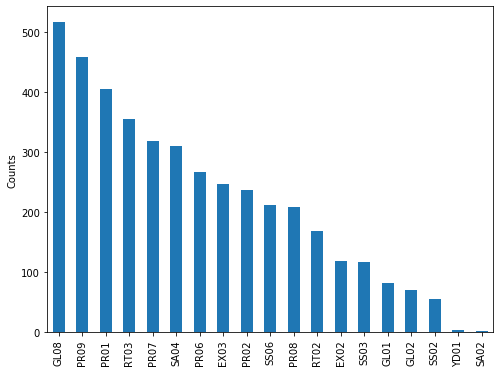

In [7]:
plot_code = pd_countplot(df_code, 'error_code','counts')

## 3) Check a frequency table of errors based on error_name

In [8]:
df_name= pd.DataFrame(df['error_name'].value_counts())
df_name.head(2)

,error_name
The object does not have a docstring,517
Return value has no description,355


# 2. Make a barplot using bqplot

In [9]:
x_scale = scales.OrdinalScale()

In [10]:
# barplot function using bqplot
def bq_barplot(df):
    # scales
    x_scale = scales.OrdinalScale()
    y_scale = scales.LinearScale()
    # x axis    
    x_ax = Axis(label='', 
                    scale=x_scale,
                    grid_lines='none',
                    orientation='horizontal', 
                    tick_rotate = -45,
                    tick_style = {'text-anchor': 'end'}) 
    # y axis
    y_ax = Axis(label='Counts', 
                scale=y_scale,  
                orientation='vertical', 
                grid_lines='none',
                label_location ='middle',
                label_offset ='50 px',
                tick_format='0f')

    # bar chart
    bar_chart = Bars(x=df.error_code,
                     y=df.counts,
                     scales={'x': x_scale, 'y': y_scale})
    # Figure
    fig = Figure(axes=[x_ax, y_ax], marks=[bar_chart]) 
    return fig 



In [11]:
code_barplot = bq_barplot(df_code)
code_barplot

Figure(axes=[Axis(grid_lines='none', scale=OrdinalScale(), tick_rotate=-45, tick_style={'text-anchor': 'end'})…

# 3. Make an editable table using qgrid

In [12]:
# Define qgrid widget
qgrid.set_grid_option('maxVisibleRows', 10)
col_opts = { 
    'editable': False,
}

In [13]:
def on_row_selected(change):
    """callback for row selection: update selected points in scatter plot"""
    filtered_df = qgrid_widget.get_changed_df()           
    team_scatter.selected = filtered_df.iloc[change.new].index.tolist()

# show_grid()    
qgrid_widget = qgrid.show_grid(df, show_toolbar=True, column_options=col_opts)
qgrid_widget.observe(on_row_selected, names=['_selected_rows'])
qgrid_widget.layout = widgets.Layout(width='920px')
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# 4. Interactive controls plot and table

## widgets

### 1) Filter data with slider

In [14]:
@interact
def show_errors_more_than(column='counts', x=100):
    df_code = df['error_code'].value_counts().reset_index()
    df_code.columns = ['error_code','counts']
    display(HTML(f'<h3>Showing error_codes with more than {x} {column}<h3>'))
    return df_code.loc[df_code[column] > x]
    
#qgrid_widget = qgrid.show_grid(df, show_toolbar=True, column_options=col_opts)
#qgrid_widget.observe(on_row_selected, names=['_selected_rows'])
#qgrid_widget.layout = widgets.Layout(width='920px')
 #  return qgrid_widget


interactive(children=(Text(value='counts', description='column'), IntSlider(value=100, description='x', max=30…

## 2) dropdown

In [15]:
#@interact
Dropdown(
    options=df_code.error_code.sort_values(),
    #value='2',
    description='Number:',
    disabled=False,
)



Dropdown(description='Number:', options=('EX02', 'EX03', 'GL01', 'GL02', 'GL08', 'PR01', 'PR02', 'PR06', 'PR07…

## 3) Dependent widgets

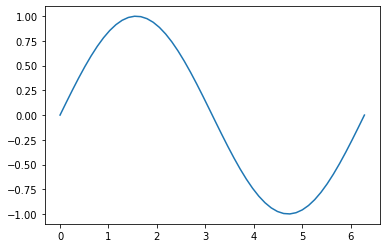

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

In [16]:
x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))
@interact
def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update);

## 3) Layout

In [17]:
AppLayout(header=widgets.Text('layout'),
          left_sidebar= widgets.Text('layout left'),
          center=widgets.IntSlider(min=-5, max=5, value=1, description='Slider'),
          right_sidebar= widgets.Text('layout right'),
          grid_gap='20px',
          justify_items='center',
          align_items='center')

AppLayout(children=(Text(value='layout', layout=Layout(grid_area='header')), Text(value='layout left', layout=…

## 4. Capture widget output

In [18]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [19]:
output= widgets.Output()
plot_output=widgets.Output()
# 1) define widgets
dropdown_code = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_code.error_code))
bounded_counts = widgets.BoundedFloatText(min=0, max= 10000, value=5,step=1, description ='Counts:')

In [20]:
def common_filtering(code,counts):
    output.clear_output()
    plot_output.clear_output()
    # no filtering
    if (code ==ALL):
        common_filter = df_code
    # filter by code
    else:
        common_filter = df_code[df_code.error_code ==code]
    # capture table output 
    with output:
        display(common_filter)
    # capture plot output 
    with plot_output:
        sns.set(style="whitegrid")
        ax=sns.barplot(x='error_code', y='counts', data=common_filter)
        plt.xticks(rotation=45)
        plt.xlabel("Error code")
        plt.ylabel("Counts")
        plt.show()
          

In [21]:
def dropdown_code_eventhandler(change):
    common_filtering(change.new,bounded_counts.value)
def bounded_counts_eventhandler(change):
    common_filtering(dropdown_code.value,change.new)      

In [22]:
dropdown_code.observe(dropdown_code_eventhandler, names='value')
bounded_counts.observe(bounded_counts_eventhandler,names='value')

### Add dashboard layout

In [23]:
input_widgets = widgets.HBox(
[dropdown_code, bounded_counts])

### Create a container for the output

In [24]:
tab = widgets.Tab([output, plot_output])
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'Bar Plot')

### Stack a dashboard

In [25]:
dashboard = widgets.VBox([input_widgets, tab])
display(dashboard)